### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [164]:
# You will need to download any word embeddings required for your code, e.g.:
# ! pip install sacremoses
# ! pip install transformers
# !wget http://nlp.stanford.edu/data/glove.6B.zip -P /vol/bitbucket/rp3317/data/
# !unzip /vol/bitbucket/rp3317/data/glove.6B.zip -d /vol/bitbucket/rp3317/data/

     |████████████████████████████████| 1.9 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 61.8 MB/s eta 0:00:01     |███████████████▎                | 1.5 MB 61.8 MB/s eta 0:00:01


In [274]:
# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch
# ! pip install swifter
# !wget https://cs.rochester.edu/u/nhossain/semeval-2020-task-7-dataset.zip -P data/
# !unzip data/semeval-2020-task-7-dataset.zip

In [12]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm" -O newsdata.zip && rm -rf /tmp/cookies.txt
!unzip newsdata.zip

--2021-03-01 12:21:20--  https://docs.google.com/uc?export=download&confirm=L_US&id=1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm
Resolving docs.google.com (docs.google.com)... 2a00:1450:4009:817::200e, 172.217.169.14
Connecting to docs.google.com (docs.google.com)|2a00:1450:4009:817::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-80-docs.googleusercontent.com/docs/securesc/1ibjbqmv2pnkirj6blrql7f5ftjp04cg/9rs149kpjsel6chmcn082f9bcf7401ko/1614601275000/16703018712613523847/08769474311849947251Z/1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm?e=download [following]
--2021-03-01 12:21:20--  https://doc-0o-80-docs.googleusercontent.com/docs/securesc/1ibjbqmv2pnkirj6blrql7f5ftjp04cg/9rs149kpjsel6chmcn082f9bcf7401ko/1614601275000/16703018712613523847/08769474311849947251Z/1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm?e=download
Resolving doc-0o-80-docs.googleusercontent.com (doc-0o-80-docs.googleusercontent.com)... 2a00:1450:4009:806::2001, 216.58.204.65
Connecting

In [296]:
# Imports

import torch
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from tqdm.notebook import tqdm_notebook
from collections import defaultdict
tqdm_notebook.pandas()


In [2]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [59]:
# Load data
train_df = pd.read_csv('data/train.csv')
funlines_df = pd.read_csv('data/train_funlines.csv')
test_df = pd.read_csv('data/dev.csv')
news_df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
all_headlines = list(train_df['original']) + list(funlines_df['original'])

In [60]:
news_df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Named Entity Recognition
Casing of headlines makes traditional NER harder, train a statistical true caser then give to bert uncased model / use spacy NER

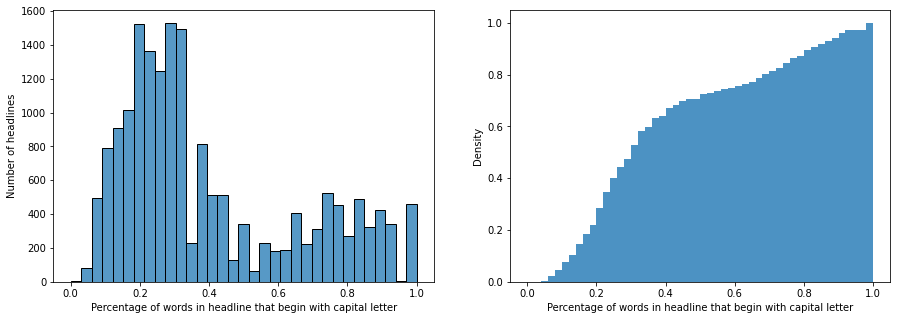

In [395]:
import re 
upperalpha = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
punctuation = string.punctuation + "‘’”“’'/-\\."
hasCap = lambda x: (x[0] in upperalpha) or x[0].isdigit() if len(x) > 0 else False
def percentageCap(sentence):
    cleaned = re.sub(r"<(.*)\/>", "\g<1>", sentence).strip(punctuation).split(' ')
    return (len([w for w in cleaned if hasCap(w)]) / len(cleaned), ' '.join(cleaned))

cap_headlines = np.array([percentageCap(h) for h in all_headlines])
fig, ax =plt.subplots(1,2, figsize=(15,5))
caps = cap_headlines[:,0].astype(float)

sns.histplot(caps, ax=ax[0])
ax[0].set(xlabel='Percentage of words in headline that begin with capital letter', ylabel='Number of headlines')

ax[1].set_xlabel('Percentage of words in headline that begin with capital letter')
ax[1].set_ylabel('Density')
ax[1]=plt.hist(caps,cumulative=True, density=True, bins=50, alpha=0.8)
plt.show()

In [152]:
from sacremoses import MosesTruecaser, MosesTokenizer
headlines_less_than = lambda limit: cap_headlines[caps < limit][:,1] 
headlines_more_than = lambda limit: cap_headlines[caps > limit][:,1] 

mtr = MosesTruecaser()
mtok = MosesTokenizer(lang='en')
tokenized_docs = [mtok.tokenize(line) for line in headlines_less_than(0.45)]
truecase_results = mtr.train(tokenized_docs, save_to='big.truecasemodel')

In [192]:

def truecase(headline):
    s = mtr.truecase(headline.lower(), return_str=True)
    return s

truecase(np.random.choice(headlines_more_than(0.8)))

'are women candidates winning more in 2018'

In [214]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER-uncased")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER-uncased")
# ! python -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')


In [270]:
class EntityTagger:
    def __init__(self):
        self.nlp = pipeline("ner", model=model, tokenizer=tokenizer, device=0)
    
    def _next_word_is_connected(self, results, i):
        return (i < len(results) - 1) and \
                results[i+1]['word'].startswith('##') and \
                results[i]['end'] == results[i+1]['start'] \
        
    def _process_results(self, results):
        if not results:
            return []
        words = []
        cur_word = ""
        cur_start = results[0]['start']
        for i, r in enumerate(results):
            cur_word += re.sub("##(.*)", "\g<1>", r['word'])
            if not self._next_word_is_connected(results, i):
                words.append(dict(word=cur_word, type=r['entity'][2::], start=cur_start, end=r['end']))
                cur_word = ""
                cur_start = results[i+1]['start'] if i < len(results) - 1 else results[i]['start']
            
        return words
            
    def tag(self, text):
        results = nlp(text)
        return self._process_results(results)

tagger = EntityTagger()
# example = "Visa , Mastercard , Stripe , and eBay all quit Facebook ’s Libra in one day"
example = np.random.choice(headlines_more_than(0.7))
tagger.tag(example)

[{'word': 'stephen', 'type': 'PER', 'start': 0, 'end': 7},
 {'word': 'king', 'type': 'PER', 'start': 8, 'end': 12},
 {'word': 'melania', 'type': 'PER', 'start': 31, 'end': 38},
 {'word': 'trump', 'type': 'PER', 'start': 39, 'end': 44}]

In [426]:
from spacy.lang.en import English
class PreProcessor():
    def __init__(self, remove_stops=False):
        self.tagger = English()
        self.remove_stops = remove_stops
    
    def process(self,row): 
        e, o = row['edit'], row['original']
        replaced = re.sub(r"<(.*)\/>", r"\g<1>", row['original']).translate(str.maketrans('','', punctuation))
        doc = self.tagger(replaced)
        doc = [t for t in doc if t.text not in punctuation]
        doc = [t for t in doc if not t.is_space] # Remove space tokens
        if self.remove_stops:
            doc = [t for t in doc if not (t.is_stop and t.text != e)] # Ensure edits aren't removed if they are stop words
        return " ".join([d.text for d in doc])

In [415]:
import pickle
preprocessor = PreProcessor(remove_stops=False)
train_df['cleaned'] = train_df.progress_apply(preprocessor.process, axis=1)
train_df['entity_tags'] = train_df.progress_apply(lambda x: tagger.tag(x['cleaned']), axis=1)
with open("traindf.pkl", "wb") as f:
    pickle.dump(train_df, f)

  0%|          | 0/9652 [00:00<?, ?it/s]

Text(0, 0.5, 'Occurences')

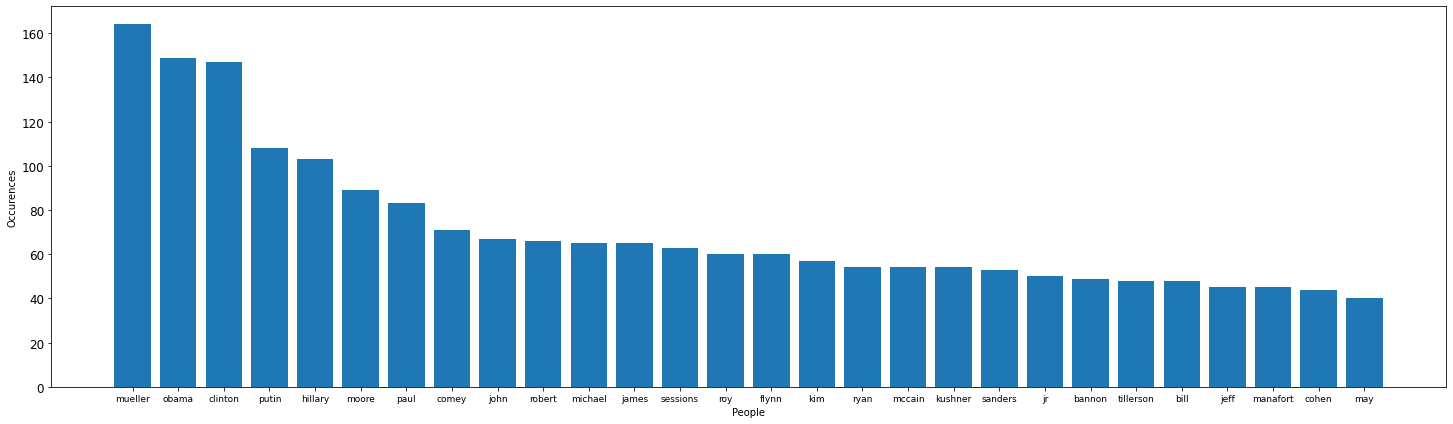

In [424]:
def get_unique_entities():
    unique = defaultdict(lambda: defaultdict(int))
    for i, entities in enumerate(train_df['entity_tags']):
        for e in entities:
            unique[e['type']][e['word']] += 1
    return unique
entities = get_unique_entities()
names = np.array(sorted(entities['PER'].items(), key=lambda x: x[1])[::-1])
counts = names[:,1].astype(int)
# for i, c in enumerate(counts):
#     print(f"{names[i][0]} - {c * 100 / sum(counts):.2f}%")
fig = plt.figure(figsize=(25,7))
plt.bar(names[:,0][2:30],counts[2:30])
fig.axes[0].tick_params(axis="x", labelsize=9)
fig.axes[0].tick_params(axis="y", labelsize=12)
fig.axes[0].set_xlabel("People")
fig.axes[0].set_ylabel("Occurences")

In [427]:
train_df['cleaned_no_stops'] = train_df.progress_apply(PreProcessor(remove_stops=True).process, axis=1)

  0%|          | 0/9652 [00:00<?, ?it/s]

# Data exploration
- 0 - not funny
- 1 - slightly funny
- 2 - moderately funny
- 3 - very funny

<AxesSubplot:xlabel='meanGrade', ylabel='Count'>

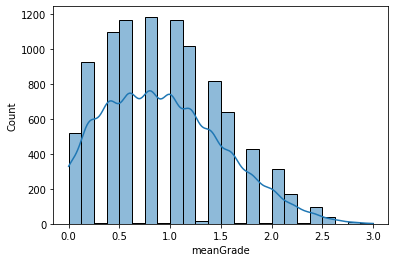

In [187]:
sns.histplot(train_df.meanGrade, kde=True, bins=24)

<AxesSubplot:xlabel='grades', ylabel='count'>

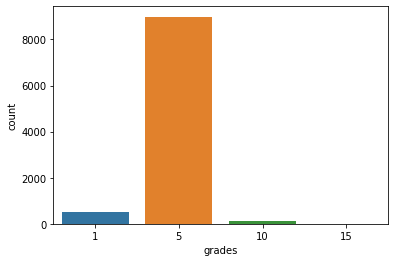

In [5]:
# Number of people grading each example
sns.countplot(x="grades", data=pd.DataFrame(train_df.grades.apply(lambda x : len(str(x))), columns=['grades']))

In [258]:
def getExamplesForFunninessBetween(f1, f2):
    mg = train_df['meanGrade']
    return train_df[((mg < f2) & (mg > f1))]
def showSamples(n):
    for i in range(3):
        d = getExamplesForFunninessBetween(i, i+1).sample(n)
        for i in range(n):
            cell = d.iloc[i]
            print(f"{cell['meanGrade']} - {cell['edit']:>12} - {cell['original']}")

showSamples(3)

0.8 -       sewage - Entry Ban Could Cause <Doctor/> Shortages in Trump Territory , New Research Finds
0.8 -        count - ' What are they trying to <hide/> ? ' Trump slams election officials over voter data request
0.2 -        mayor - Nearly everyone around <Trump/> is being more critical of Charlottesville than he is
1.4 -         ends - FCC chairman <defends/> First Amendment after Trump broadcaster threats
1.2 -       coffee - Enraged Bernie Supporter Opens Fire on Republicans After Realizing he Ca n't Get a <Refund/> 
1.4 -     hamsters - Google Search Is Doing Irreparable Harm To <Muslims/> 
2.4 -         Acid - Barack Obama threatens to upstage Donald Trump 's <Europe/> trip as he visits Germany
2.4 -      blankie - Ex-President Luiz Inacio Lula da Silva defies court order to turn himself into police , hunkers down with <supporters/> .
2.4 -          rib - Trump holds joint press conference with Norway 's prime <minister/> — live updates


# Preprocessing
- Replace words in original with edit
- Tokenise with spacy
- Remove punctuation symbols
- lowercase 
- Delete stop words

## Ideas
- Compare POS tag of old/new sentence
- Make a language model on news articles and check perplexity/probability of edit = https://www.kaggle.com/rmisra/news-category-dataset
- LDA model on real headlines - if its not part of the top 50 topics then probably out of domain
- Check probability of all n-gram pairs surrounding edit
- https://www.scribendi.ai/can-we-use-bert-as-a-language-model-to-assign-score-of-a-sentence/


In [84]:
import re 
import string
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

punctuation = set(string.punctuation + '‘’”“')
pd.set_option('display.max_colwidth', None)

def process(row): 
    e, o = row['edit'], row['original']
    replaced = re.sub(r"<.*\/>", e, o)
    doc = nlp(replaced)
    doc = [t for t in doc if t.text not in punctuation]
    doc = [t for t in doc if not (t.is_stop and t.text != e)] # Ensure edits aren't removed if they are stop words
    doc = [t for t in doc if not t.is_space] # Remove space tokens
    return doc

In [85]:
train_df['edited'] = train_df.apply(process, axis=1)
train_df.head(10)['edited']

0                         [France, hunting, citizens, joined, twins, trial, Iraq]
1    [Pentagon, claims, 2,000, increase, Russian, trolls, bowling, strikes, mean]
2              [Iceland, PM, Calls, Snap, Vote, Pedophile, Furor, Crashes, party]
3                                      [apparent, Iran, Israel, slap, militarily]
4                     [Trump, told, weeks, ago, Flynn, misled, school, President]
5                                    [22, sounds, Trump, speech, Congress, chart]
6                               [New, DOJ, alert, system, flag, laughter, police]
7             [Grew, Fundamentalist, morons, m, Surprised, Surprised, Roy, Moore]
8                                     [Canadians, pay, taxes, Americans, loonies]
9                                   [Dutch, minister, resigns, drug, baron, blow]
Name: edited, dtype: object

In [86]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

In [7]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """
    print("Training model.")
    for epoch in range(1, number_epoch+1):
        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:
            feature, target = batch
            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            optimizer.zero_grad()
            loss = loss_fn(predictions, target)
            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)
        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [8]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [9]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [10]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    for sentence in data:
        tokenized_sentence = []
        for token in sentence.split(' '): # simplest split is
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [11]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()
    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [12]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

In [14]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

# This is a large file, it will take a while to load in the memory!
glove_file = '/vol/bitbucket/rp3317/data/glove.6B.100d.txt'
with codecs.open(glove_file, 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs)

Vocab created.
Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 02 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 03 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 04 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.58 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 05 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 06 | Train Loss: 0.29 | Train MSE: 0.29 | Train RMSE: 0.54 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.26 | Train MSE: 0.26 | Train RMSE: 0.51 |         Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epo

#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |
